# Intro to MCMC Tutorial Notebook

This notebook contains a few exercises you can try based on the high-level concepts from the Lecture Slides notebook.  It also contains a few longer worked examples that reflect particular possible applications of these methods.

As with the Lecture Slides notebook, the top of this notebook contains some high-level template code that will make it easier for us to work with different kinds of samplers.  Scroll down to get to the actual applied examples.

## Resources

* [Chib & Greenberg 1998, "Understanding the Metropolis-Hastings algorithm"](https://stat.duke.edu/~scs/Courses/Stat376/Papers/Basic/ChibGreenberg1995.pdf)

* [Gelman & Rubin 1992, "Inference from Iterative Simulation Using Multiple Sequences"](http://stat.duke.edu/~scs/Courses/Stat376/Papers/ConvergeDiagnostics/GelmanRubinStatSci1992.pdf)

* [Hogg, Bovy, & Lang 2010, "Data analysis recipes: Fitting a model to data"](https://arxiv.org/abs/1008.4686/)

* [Kroese, "Handbook of Monte Carlo"](https://people.smp.uq.edu.au/DirkKroese/montecarlohandbook/)

In [1]:
%matplotlib notebook

import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, stats

## General-purpose functions to use throughout the notebook

In [2]:
# Some generally useful utility functions

def profile_timer(f, *args, **kwargs):
    """
    Times a function call f() and prints how long it took in seconds
    (to the nearest millisecond).
    :param func:  the function f to call
    :return:  same return values as f
    """
    t0 = time.time()
    result = f(*args, **kwargs)
    t1 = time.time()
    print ("time to run {}: {:.3f} sec".format(f.__name__, t1-t0))
    return result

def movieify(plfunc, x, frame_idx, *args, **kwargs):
    """
    Saves figures to a directory to be compiled as an animated GIF.
    :param plfunc:  plotting function to call, which it is assumed
        will initialize a new plt.figure() instance
    :param x:  the input data to plfunc, as an np.array of shape
        (Nsamples, ...); the function will take successive subsets
        of the data to show the progress of sampling
    """
    for Nf in frame_idx:
        savefigfn = "{}_frame_{:06d}.png".format(plfunc.__name__, Nf)
        plfunc(x[:Nf], *args, savefigfn=savefigfn, **kwargs)

## MCMC template code (copied from riemann GitHub)

The following code is general-purpose and is cribbed from my GitHub repo at:  https://github.com/rscalzo/riemann

At this stage it's easier to just cut and paste it since you may want to play with it, rather than simply creating a dependency on the library.  But you can always clone (or fork) the library if you want to see more.  In particular, the GitHub code makes the class hierarchy and the relationships between objects clearer.

### Metropolis-Hastings sampler code (Sampler object)

In [3]:
class MHSampler(object):
    """
    Run a Metropolis-Hastings algorithm given a Model and Proposal.
    """

    def __init__(self, model, proposal, debug=False):
        """
        Initialize a Sampler with a model, a proposal, data, and a guess
        at some reasonable starting parameters.
        :param model: callable accepting a np.array parameter vector
            of shape matching the initial guess theta0, and returning
            a probability (such as a posterior probability)
        :param proposal: callable accepting a np.array parameter vector
            of shape matching the initial guess theta0, and returning
            a proposal of the same shape, as well as the log ratio
                log (q(theta'|theta)/q(theta|theta'))
        :param theta0: np.array of shape (Npars,)
        :param debug: Boolean flag for whether to turn on the debugging
            print messages in the sample() method
        """
        self.model = model
        self.proposal = proposal
        self._chain_thetas = [ ]
        self._chain_logPs = [ ]
        self._debug = debug

    def run(self, theta0, Nsamples):
        """
        Run the Sampler for Nsamples samples.
        """
        self._chain_thetas = [ theta0 ]
        self._chain_logPs = [ self.model(theta0) ]
        for i in range(Nsamples):
            theta, logpost = self.sample()
            self._chain_thetas.append(theta)
            self._chain_logPs.append(logpost)
        self._chain_thetas = np.array(self._chain_thetas)
        self._chain_logPs = np.array(self._chain_logPs)

    def sample(self):
        """
        Draw a single sample from the MCMC chain, and accept or reject
        using the Metropolis-Hastings criterion.
        """
        theta_old = self._chain_thetas[-1]
        logpost_old = self._chain_logPs[-1]
        theta_prop, logqratio = self.proposal(theta_old)
        logpost = self.model(theta_prop)
        mhratio = min(1, np.exp(logpost - logpost_old - logqratio))
        if self._debug:
            # this can be useful for sanity checks
            print("theta_old, theta_prop =", theta_old, theta_prop)
            print("logpost_old, logpost_prop =", logpost_old, logpost)
            print("logqratio =", logqratio)
            print("mhratio =", mhratio)
        if np.random.uniform() < mhratio:
            return theta_prop, logpost
        else:
            return theta_old, logpost_old
        
    def chain(self):
        """
        Return a reference to the chain.
        """
        return self._chain_thetas
    
    def accept_frac(self):
        """
        Calculate and return the acceptance fraction.  Works by checking which
        parameter vectors are the same as their predecessors.
        """
        samesame = (self._chain_thetas[1:] == self._chain_thetas[:-1])
        if len(samesame.shape) == 1:
            samesame = samesame.reshape(-1, 1)
        samesame = np.all(samesame, axis=1)
        return 1.0 - (np.sum(samesame) / np.float(len(samesame)))

### Multi-dimensional Gaussian distribution (Model object)

In [4]:
class MultiGaussianDist(object):
    """
    A multivariate Gaussian distribution with known mean and covariance.
    Probably a little over-engineered for a one-dimensional Gaussian...
    """

    def __init__(self, mu, C):
        """
        :param mu: mean; np.array of shape (Ndim,)
        :param C: covariance; np.array of shape (Ndim, Ndim)
        """
        # Sanity checks for input
        mu = np.atleast_1d(mu)
        C = np.atleast_2d(C)
        if C.shape[0] != C.shape[1]:
            raise ParameterError("C has non-square shape {}".format(C.shape))
        if C.shape[1] != mu.shape[0]:
            raise ParameterError("mu and C have incompatible shapes {}, {}"
                                 .format(mu.shape, C.shape))
        # Cache Cholesky factor and log det for later use
        self.mu = mu
        self.L = linalg.cholesky(C, lower=True)
        self.logdetC = 2*np.sum(np.log(np.diag(self.L)))
        self.Ndim = len(mu)

    def log_prior(self, theta):
        return 0.0

    def log_likelihood(self, theta):
        y = theta - self.mu
        u = linalg.solve_triangular(self.L, y, lower=True)
        return -0.5*(np.dot(u, u) + len(y)*np.log(2*np.pi) + self.logdetC)
    
    def log_posterior(self, theta):
        return self.log_prior(theta) + self.log_likelihood(theta)
    
    def __call__(self, theta):
        return self.log_posterior(theta)

    def draw(self, Ndraws=1):
        """
        Draw from the Gaussian with these parameters.
        :return: np.array with shape (Ndraws, Ndim)
        """
        epsilon = np.random.normal(size=(Ndraws, self.mu.shape[0]))
        print("self.L.shape =", self.L.shape)
        eL = np.dot(epsilon, self.L.T)
        return eL + self.mu[None,:]

### Test harness to set up and run a random walk

In [5]:
def test_MHRW_Sampler(logpost, theta0, stepsize, Nsamp=100000):
    """
    Simple test that samples a 1-D distribution using MHSampler
    """
    # Run the chain
    sampler = MHSampler(logpost, GaussianProposal(stepsize))
    sampler.run(theta0, Nsamp)
    print("chain.mean, chain.std =", sampler.chain().mean(), sampler.chain().std())
    print("acceptance fraction =", sampler.accept_frac())
    return sampler.chain()

### Discrete autocorrelation function of a time series

In [6]:
def autocorr(x, D, plot=True):
    """
    Discrete autocorrelation function + integrated autocorrelation time.
    Calculates directly, though could be sped up using Fourier transforms.
    See Daniel Foreman-Mackey's tutorial (based on notes from Alan Sokal):
    https://emcee.readthedocs.io/en/stable/tutorials/autocorr/

    :param x: np.array of data, of shape (Nsamples, Ndim)
    :param D: number of return arrays
    """
    # Baseline discrete autocorrelation:  whiten the data and calculate
    # the mean sample correlation in each window
    xp = np.atleast_2d(x)
    z = (xp-np.mean(xp, axis=0))/np.std(xp, axis=0)
    Ct = np.ones((D, z.shape[1]))
    Ct[1:,:] = np.array([np.mean(z[i:]*z[:-i], axis=0) for i in range(1,D)])
    # Integrated autocorrelation tau_hat as a function of cutoff window M
    tau_hat = 1 + 2*np.cumsum(Ct, axis=0)
    # Sokal's advice is to take the autocorrelation time calculated using
    # the smallest integration limit M that's less than 5*tau_hat[M]
    Mrange = np.arange(len(tau_hat))
    tau = np.argmin(Mrange[:,None] - 5*tau_hat, axis=0)
    print("tau =", tau)
    # Plot if requested
    if plot:
        fig = plt.figure(figsize=(6,4))
        plt.plot(Ct)
        plt.title('Discrete Autocorrelation ($\\tau = {:.1f}$)'.format(np.mean(tau)))
    return np.array(Ct), tau

### Trace plots (shows traces of all parameters with shared, resizeable axis limits)

In [7]:
def traceplots(x, xnames=None, title=None):
    """
    Runs trace plots.
    :param x:  np.array of shape (N, d)
    :param xnames:  optional iterable of length d, containing the names
        of variables making up the dimensions of x (used as y-axis labels)
    :param title:  optional plot title
    """
    # set out limits of plot spaces, in dimensionless viewport coordinates
    # that run from 0 (bottom, left) to 1 (top, right) along both axes
    N, d = x.shape
    fig = plt.figure()
    left, tracewidth, histwidth = 0.1, 0.65, 0.15
    bottom, rowheight = 0.1, 0.8/d
    spacing = 0.05
    
    for i in range(d):
        # Set the location of the trace and histogram viewports,
        # starting with the first dimension from the bottom of the canvas
        rowbottom = bottom + i*rowheight
        rect_trace = (left, rowbottom, tracewidth, rowheight)
        rect_hist = (left + tracewidth, rowbottom, histwidth, rowheight)
        # First set of trace plot axes
        if i == 0:
            ax_trace = fig.add_axes(rect_trace)
            ax_trace.plot(x[:,i])
            ax_trace.set_xlabel("Sample Count")
            ax_tr0 = ax_trace
        # Other sets of trace plot axes that share the first trace's x-axis
        # Make tick labels invisible so they don't clutter up the plot
        elif i > 0:
            ax_trace = fig.add_axes(rect_trace, sharex=ax_tr0)
            ax_trace.plot(x[:,i])
            plt.setp(ax_trace.get_xticklabels(), visible=False)
        # Title at the top
        if i == d-1 and title is not None:
            plt.title(title)
        # Trace y-axis labels
        if xnames is not None:
            ax_trace.set_ylabel(xnames[i])
        # Trace histograms at the right
        ax_hist = fig.add_axes(rect_hist, sharey=ax_trace)
        ax_hist.hist(x[:,i], orientation='horizontal', bins=50)
        plt.setp(ax_hist.get_xticklabels(), visible=False)
        plt.setp(ax_hist.get_yticklabels(), visible=False)
        xlim = ax_hist.get_xlim()
        ax_hist.set_xlim([xlim[0], 1.1*xlim[1]])

### Potential scale reduction factor (Gelman & Rubin 1992)

In [8]:
def gelman_rubin(data):
    """
    Apply Gelman-Rubin convergence diagnostic to a bunch of chains.
    :param data: np.array of shape (Nchains, Nsamples, Npars)
    """
    Nchains, Nsamples, Npars = data.shape
    B_on_n = data.mean(axis=1).var(axis=0)      # variance of in-chain means
    W = data.var(axis=1).mean(axis=0)           # mean of in-chain variances

    # simple version, as in Obsidian -- not reliable on its own!
    sig2 = (Nsamples/(Nsamples-1))*W + B_on_n
    Vhat = sig2 + B_on_n/Nchains
    Rhat = Vhat/W

    # advanced version that accounts for ndof
    m, n = np.float(Nchains), np.float(Nsamples)
    si2 = data.var(axis=1)
    xi_bar = data.mean(axis=1)
    xi2_bar = data.mean(axis=1)**2
    var_si2 = data.var(axis=1).var(axis=0)
    allmean = data.mean(axis=1).mean(axis=0)
    cov_term1 = np.array([np.cov(si2[:,i], xi2_bar[:,i])[0,1]
                          for i in range(Npars)])
    cov_term2 = np.array([-2*allmean[i]*(np.cov(si2[:,i], xi_bar[:,i])[0,1])
                          for i in range(Npars)])
    var_Vhat = ( ((n-1)/n)**2 * 1.0/m * var_si2
             +   ((m+1)/m)**2 * 2.0/(m-1) * B_on_n**2
             +   2.0*(m+1)*(n-1)/(m*n**2)
                    * n/m * (cov_term1 + cov_term2))
    df = 2*Vhat**2 / var_Vhat
    print ("gelman_rubin(): var_Vhat = {}, df = {}".format(var_Vhat, df))
    Rhat *= df/(df-2)
    
    return Rhat

## Week 2 Assessment Problem:  Proposal bake-off on an odd-shaped Gaussian mixture

Consider the 2-dimensional Gaussian mixture distribution with density

$$ p(x,y) \propto \exp \left( -\frac{x^2}{200} - \frac{y^2}{2} \right)
                + \exp \left( -\frac{x^2}{2} - \frac{y^2}{200} \right) $$
                
Choose any three out of the following four Monte Carlo integration schemes to implement:

1. Accept-reject sampling (your choice of dominating function);
2. Independence MCMC (your choice of proposal density);
3. Metropolis random walk (your choice of walk _except_ isotropic Gaussian);
4. Gibbs sampling.

You can use any of the stock infrastructure given at the top of the notebook, or in the Lecture Slides notebook.  This means you should only have to fill in the `__init__` and `__call__` methods of the `Proposal` class, although you can write or modify other classes if that helps you.

Comment on the relative efficiency of the proposals with reference to the acceptance rate, autocorrelation time, PSRF, and CPU/wall time per autocorrelation time.  Can you see indications in the trace plots of how each proposal is working?

<IPython.core.display.Javascript object>


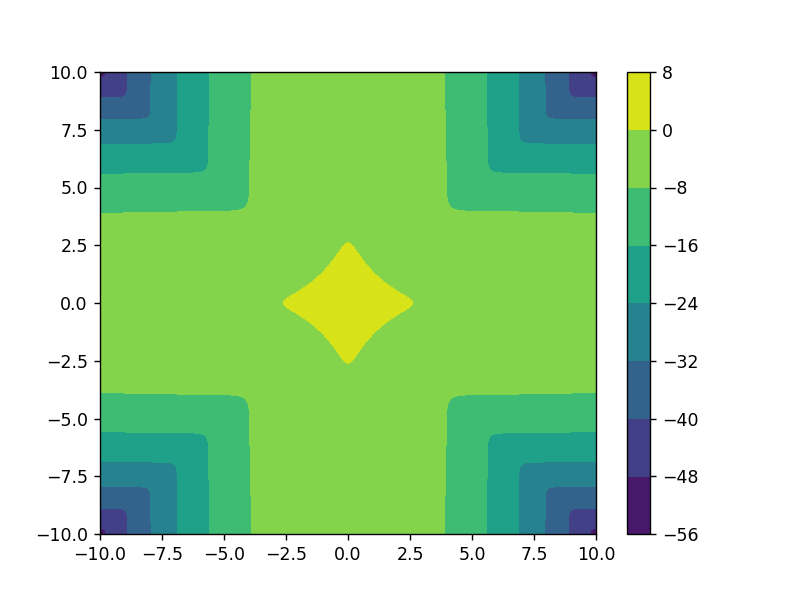

In [9]:
# Let's plot this density and see how it looks

class WackyLogPost(object):
    
    def __init__(self):
        # Initialize internal parameters; lets you experiment w/different shapes
        self.s1, self.s2 = 10.0, 1.0
    
    def __call__(self, theta):
        # The un-normalized version of the density, since this is for MCMCtheta
        x, y, = theta
        return np.log(np.exp(-0.5*(x**2/self.s1**2 + y**2/self.s2**2))
                    + np.exp(-0.5*(x**2/self.s2**2 + y**2/self.s1**2)))
    
    def conditional_draw(self, theta, i):
        """
        A stub that you might find handy for setting up a Gibbs proposal
        within the MHSampler software framework.
        :param theta:  parameter vector = np.array of shape (d,)
        :param i:  dimension to sample along
        """
        # TODO:  your mission, should you choose to accept it
        return None

logpost = WackyLogPost()    

fig = plt.figure()
xl, yl = np.linspace(-10, 10, 201), np.linspace(-10, 10, 201)
xg, yg = np.meshgrid(xl, yl)
xg, yg = xg.ravel(), yg.ravel()
Lg = logpost(np.array([xg, yg]))
plt.tricontourf(xg, yg, Lg)
plt.colorbar()

# Accept Reject

In [10]:
import numpy as np
from scipy import special, stats

In [11]:
# Number of samples
N = 10000
# proposal multivariate normal distribution
rv = stats.multivariate_normal([0.0, 0.0], 100)
# generate samples from proposal distribution
x = rv.rvs(size=N)
# sample from uniform distribution to apply accept-reject procedure
y = np.random.uniform(size=N)

<IPython.core.display.Javascript object>


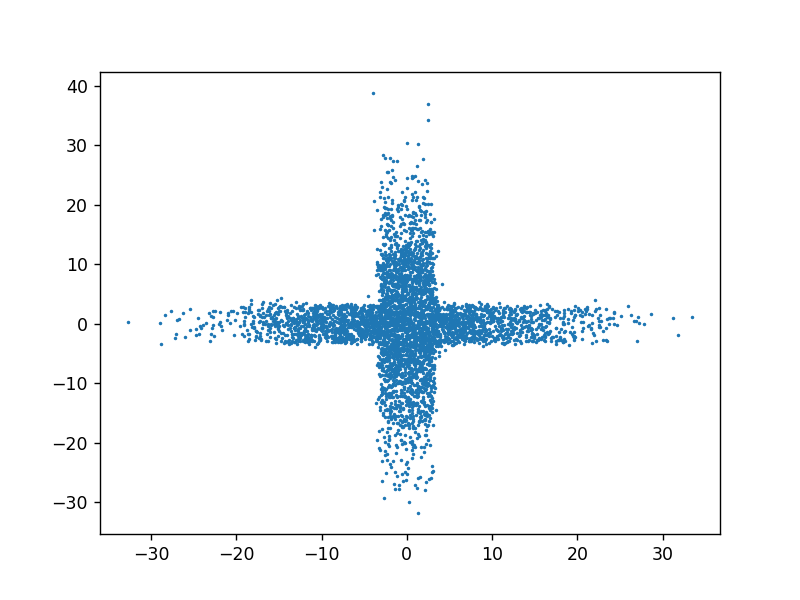

accepted_samples.mean, accepted_samples.std = 3.847086487216791e-05 7.641290359083717
acceptance fraction = 44.0%


In [12]:
# simple dominating function - a constant
M = 10
# pdf for generated samples
p = np.exp(logpost([x[:,0], x[:,1]]))

# accepted probability
q = M * rv.pdf(x)
idx = y < (p / q)

accepted_samples = x[idx]

fig = plt.figure()
plt.plot(accepted_samples[:, 0], accepted_samples[:, 1], ls='None', marker='o', ms=1)
accept_frac = np.sum(1.0 * idx) / N
print("accepted_samples.mean, accepted_samples.std =", accepted_samples.mean(), accepted_samples.std())
print("acceptance fraction = {:.1f}%".format(100.0 * accept_frac))

<IPython.core.display.Javascript object>


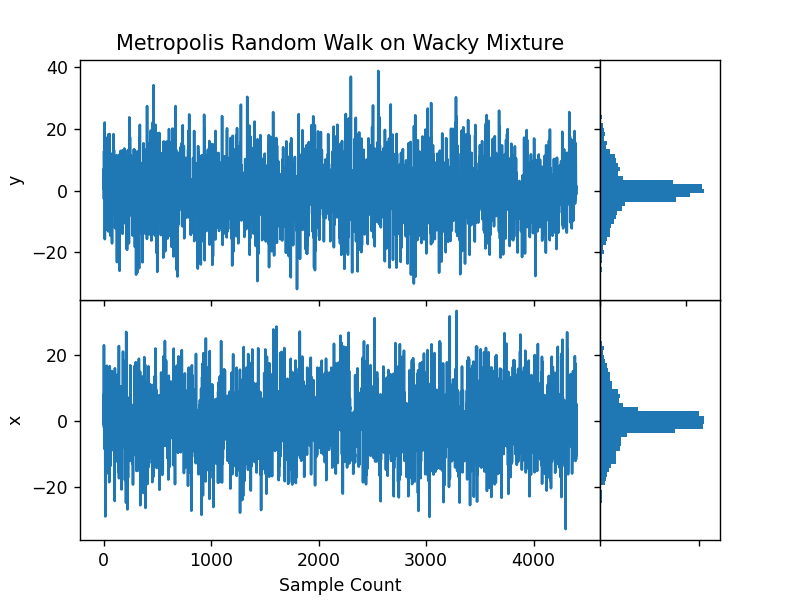

tau = [0 0]


In [13]:
traceplots(accepted_samples, xnames=['x','y'], title="Accept Reject on Wacky Mixture")
rho_k, tau = autocorr(accepted_samples, 1000, plot=False)